# Text Summarization - GRU Word2Vec

### Importing Basic libraries

In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, GRU, RNN
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
from tensorflow.python.keras.layers import Layer


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 893 kB/s            


### Importing Data

In [4]:
data = pd.read_excel('../input/inshorts-news-data/Inshorts Cleaned Data.xlsx')

In [5]:
data.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
data.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


### Punctuation and Stopword Removal

In [7]:
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    
    tokens = [w for w in text.split() if not w in stop_words]
    text = " ".join(tokens)
    text = text.replace("'s",'')
    text = text.replace(".",'')
    text = re.sub(r'\(.*\)','',text)
    text = re.sub(r'[^a-zA-Z0-9. ]',' ',text)
    text = re.sub(r'\.','. ',text)
    text = re.sub(r'\s+', ' ', text)
    return text


### Lemmatization

In [8]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [9]:
data.rename(columns={'Headline': 'headlines', 'Short': 'text'}, inplace=True)

In [10]:
original_text = str(data['text'][0])
original_headline = str(data['headlines'][0])

In [11]:
processed_text = data['text'].apply(preprocess)
data['text'] = processed_text.apply(lemmatize_text)
data['headlines'] = data['headlines'].apply(lambda x : '_START_ '+ x + ' _END_')

for i in range(2):
    print('Summary:', data['headlines'][i],'Text:', data['text'][i], sep='\n')
    print()

Summary:
_START_ 4 ex-bank officials booked for cheating bank of ₹209 crore _END_
Text:
cbi saturday book four former official syndicate bank six other cheat forgery criminal conspiracy cause 209 crore loss state run bank accuse availed home loan credit syndicate bank basis forge fabricate document fund fraudulently transfer company own accuse person

Summary:
_START_ Supreme Court to go paperless in 6 months: CJI _END_
Text:
chief justice js khehar say supreme court go paperless six seven month bid save fund make judiciary eco friendly say apex court collect record electronically low court high court need file hard copy



### Sample Input

In [12]:
print("\nORIGINAL")
print(original_text)
print(original_headline)

print("\nREGEX CLEANING AND STOPWORD REMOVAL:")
print(processed_text[0])
# print(brief_cleaned_summary[0])

print("\nLEMMATIZATION + START AND END TOKEN")
print(data['text'][0])
print(data['headlines'][0])


ORIGINAL
The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.
4 ex-bank officials booked for cheating bank of ₹209 crore

REGEX CLEANING AND STOPWORD REMOVAL:
cbi saturday booked four former officials syndicate bank six others cheating forgery criminal conspiracy causing 209 crore loss state run bank accused availed home loans credit syndicate bank basis forged fabricated documents funds fraudulently transferred companies owned accused persons

LEMMATIZATION + START AND END TOKEN
cbi saturday book four former official syndicate bank six other cheat forgery criminal conspiracy cause 209 crore loss state run bank accuse availed home loan credit syndicate bank basis 

In [13]:
headlines_length = [len(x.split()) for x in data.headlines]
text_length = [len(x.split()) for x in data.text]

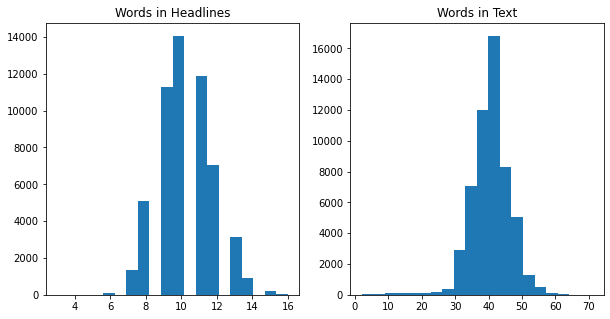

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.hist(headlines_length, bins = 20)
ax2.hist(text_length, bins = 20)

ax1.title.set_text("Words in Headlines")
ax2.title.set_text("Words in Text")
plt.show()

### Embedding Matrix from Word2Vec


In [15]:
numWords = 62369

In [16]:
from gensim.models import Word2Vec

In [17]:
sentences = [line.split(' ') for line in data['text']]
word2vec = Word2Vec(sentences = sentences, min_count = 1)


In [18]:
word2vec.wv.save_word2vec_format('word2vec_vector.txt')


In [19]:
embeddings_index = dict()
f = open('./word2vec_vector.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


Loaded 62369 word vectors.


In [20]:
def wordTokenizer(dataframe):
    tokenizer = Tokenizer(num_words = numWords, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = ' ', char_level = False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer, dataframe

In [21]:
def tokenizeAndEmbedding(dataframe):
    tokenizer_x, X = wordTokenizer(data['text'])
    tokenizer_y, Y = wordTokenizer(data['headlines'])

    embedding_matrix = np.zeros((numWords+1, 100))
    for i,word in tokenizer_x.index_word.items():
        if i<numWords+1:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    print(embedding_matrix.shape)
    return embedding_matrix

In [22]:
embedding_matrix = tokenizeAndEmbedding(data)

(62370, 100)


In [29]:
words_source_train = []
for i in data['text'] :
  words_source_train.extend(i.split(' '))

print("all the words in the corpus", len(words_source_train))
words_source_train = set(words_source_train)
print("the unique words in the corpus", len(words_source_train))
inter_words = set(embeddings_index.keys()).intersection(words_source_train)
print("The number of words that are present in both glove vectors and our corpus are {} which \
is nearly {}% ".format(len(inter_words), np.round((float(len(inter_words))/len(words_source_train))
*100)))

words_corpus_source_train = {}
words_glove = set(embeddings_index.keys())
for i in words_source_train:
  if i in words_glove:
    words_corpus_source_train[i] = embeddings_index[i]
print("word 2 vec length", len(words_corpus_source_train))

all the words in the corpus 2235816
the unique words in the corpus 62368
The number of words that are present in both glove vectors and our corpus are 62367 which is nearly 100.0% 
word 2 vec length 62367


In [30]:
print(list(words_source_train - inter_words)[:20])

['']


In [31]:
def num(text):
  words = [w for w in text.split() if not w in inter_words]
  return len(words)

data['unique_words'] = data['text'].apply(num)

In [32]:
data['unique_words'].value_counts()

0    55104
Name: unique_words, dtype: int64

In [33]:
data = data[data['unique_words'] < 4]
data.reset_index(inplace=True, drop=True)

In [34]:
data

,headlines,text,unique_words
0,_START_ 4 ex-bank officials booked for cheatin...,cbi saturday book four former official syndica...,0
1,_START_ Supreme Court to go paperless in 6 mon...,chief justice js khehar say supreme court go p...,0
2,"_START_ At least 3 killed, 30 injured in blast...",least three people kill include policeman 30 o...,0
3,_START_ Why has Reliance been barred from trad...,mukesh ambani lead reliance industry 2007 ril ...,0
4,_START_ Was stopped from entering my own studi...,tv news anchor arnab goswami say tell could pr...,0
...,...,...,...
55099,_START_ Sensex loses 400 points to hit 52-week...,track weak cue asian market benchmark sensex w...,0
55100,_START_ China to inject $91 bn into the money ...,amid grow concern china 39 s economic growth r...,0
55101,_START_ Ghulam Ali set to make acting debut in...,pakistani ghazal singer ghulam ali soon make a...,0
55102,_START_ IS acknowledges death of Jihadi John: ...,islamic state acknowledge death 39 jihadi john...,0


### Splitting Data

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['headlines'], test_size = 0.2, random_state = 20)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size = 0.5, random_state = 20)

In [36]:
max_length_x = max(text_length)
max_length_y = max(headlines_length)

### Tokenization

In [37]:
x_t = Tokenizer()
x_t.fit_on_texts(data['text'] + data['headlines'])
x_vocab_size = len(x_t.word_index) + 1

encoded_xtrain = x_t.texts_to_sequences(X_train)
encoded_xval = x_t.texts_to_sequences(X_val)
encoded_xtest = x_t.texts_to_sequences(X_test)

padded_xtrain = pad_sequences(encoded_xtrain, maxlen=max_length_x, padding='post')
padded_xval = pad_sequences(encoded_xval, maxlen=max_length_x, padding='post')
padded_xtest = pad_sequences(encoded_xtest, maxlen=max_length_x, padding='post')

In [38]:
y_t = Tokenizer()
y_t.fit_on_texts(data['headlines'])
y_vocab_size = len(y_t.word_index) + 1

encoded_ytrain = y_t.texts_to_sequences(y_train)
encoded_yval = y_t.texts_to_sequences(y_val)
encoded_ytest = y_t.texts_to_sequences(y_test)

padded_ytrain = pad_sequences(encoded_ytrain, maxlen=max_length_y, padding='post')
padded_yval = pad_sequences(encoded_yval, maxlen=max_length_y, padding='post')
padded_ytest = pad_sequences(encoded_ytest, maxlen=max_length_y, padding='post')

In [39]:
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((x_vocab_size, 100))
for word, i in x_t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 62369 word vectors.


### Building Model

In [42]:
latent_dim=80

K.clear_session() 

encoder_inputs = Input(shape=(max_length_x,)) 
enc_emb = Embedding(x_vocab_size, 100, weights=[embedding_matrix],input_length=max_length_x, trainable=False)(encoder_inputs) 

#LSTM 
encoder_lstm1 = GRU(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1 = encoder_lstm1(enc_emb) 
encoder_lstm2 = GRU(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2 = encoder_lstm2(encoder_output1) 
encoder_lstm3 = GRU(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs3, state_h3= encoder_lstm3(encoder_output2)
encoder_lstm4 = GRU(latent_dim,return_sequences=True,return_state=True) 
encoder_outputs, state_h = encoder_lstm4(encoder_outputs3) 

encoder_states = [state_h]
# Decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_vocab_size, 100, weights=[embedding_matrix],input_length=max_length_x, trainable=False) 
dec_emb = dec_emb_layer(decoder_inputs) 

# GRU using encoder_states as initial state
decoder_lstm1 = GRU(80, return_sequences=True, return_state=True) 
decoder_outputs1,decoder_fwd_state1 = decoder_lstm1(dec_emb,initial_state=[state_h]) 

decoder_lstm2 = GRU(80, return_sequences=True, return_state=True) 
decoder_outputs2,decoder_fwd_state2 = decoder_lstm2(decoder_outputs1,initial_state=[decoder_fwd_state1]) 

decoder_lstm3 = GRU(80, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state = decoder_lstm3(decoder_outputs2,initial_state=[decoder_fwd_state2]) 


decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_outputs) 

model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
print(model.summary())

2022-01-16 06:44:29.046236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 06:44:29.047394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 06:44:29.048044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 06:44:29.048806: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 71)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 71, 100)      6984400     input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       [(None, 71, 80), (No 43680       embedding[0][0]                  
__________________________________________________________________________________________________
gru_1 (GRU)                     [(None, 71, 80), (No 38880       gru[0][0]                        
______________________________________________________________________________________________

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
checkpoint_filepath = './model.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True, save_freq = "epoch")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
history=model.fit(
    [padded_xtrain,padded_ytrain[:,:-1]], 
    padded_ytrain.reshape(padded_ytrain.shape[0],padded_ytrain.shape[1], 1)[:,1:], 
    epochs=100,
    batch_size=512, 
    validation_data=([padded_xval,padded_yval[:,:-1]], padded_yval.reshape(padded_yval.shape[0],padded_yval.shape[1], 1)[:,1:]), 
    callbacks=[model_checkpoint_callback])

2022-01-16 06:44:37.833493: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-01-16 06:44:46.776392: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


87/87 [==============================] - 25s 170ms/step - loss: 6.6601 - val_loss: 5.4031
Epoch 2/100
87/87 [==============================] - 13s 153ms/step - loss: 5.1157 - val_loss: 4.9403
Epoch 3/100
87/87 [==============================] - 13s 153ms/step - loss: 4.8257 - val_loss: 4.7860
Epoch 4/100
87/87 [==============================] - 13s 153ms/step - loss: 4.7096 - val_loss: 4.7204
Epoch 5/100
87/87 [==============================] - 13s 153ms/step - loss: 4.6234 - val_loss: 4.6765
Epoch 6/100
87/87 [==============================] - 13s 154ms/step - loss: 4.5454 - val_loss: 4.5645
Epoch 7/100
87/87 [==============================] - 13s 153ms/step - loss: 4.4594 - val_loss: 4.4649
Epoch 8/100
87/87 [==============================] - 13s 153ms/step - loss: 4.3796 - val_loss: 4.4180
Epoch 9/100
87/87 [==============================] - 13s 153ms/step - loss: 4.3084 - val_loss: 4.3641
Epoch 10/100
87/87 [==============================] - 13s 153ms/step - loss: 4.2472 - val_loss

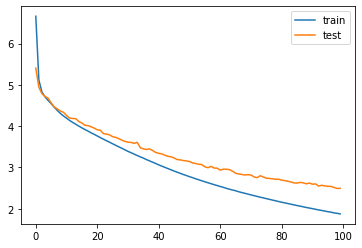

In [44]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [45]:
model.save_weights("final_weights.h5")

### Inference

In [47]:
reverse_target_word_index = y_t.index_word 
reverse_source_word_index = x_t.index_word 
target_word_index = y_t.word_index

In [48]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h])
decoder_state_input_h = Input(shape=(latent_dim,))

decoder_hidden_state_input = Input(shape=(max_length_x,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs3, state_h3 = decoder_lstm1(dec_emb2, initial_state=[decoder_state_input_h])

decoder_outputs4, state_h4 = decoder_lstm2(decoder_outputs3, initial_state=[state_h3])
decoder_outputs5, state_h5 = decoder_lstm3(decoder_outputs4, initial_state=[state_h4])

decoder_outputs5 = decoder_dense(decoder_outputs5)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h],
[decoder_outputs5] + [state_h5])

In [49]:
def decode_sequence(input_seq):
    input_seq= input_seq.reshape(1,max_length_x)
    e_out, e_h = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq] + [e_out, e_h])

        sampled_token_index = np.argmax(output_tokens[0, -1, :]) 
        sampled_token = reverse_target_word_index[sampled_token_index]
  
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
 
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_length_y-1)):
                stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h = h

    return decoded_sentence

In [50]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [51]:
print("Review:",seq2text(padded_xtest[3]))
print("Original summary:",seq2summary(padded_ytest[3]))
print("Predicted summary:",decode_sequence(padded_xtest[3]))


Review: actor tiger shroff feature cover february issue man 39 s luxury lifestyle magazine 39 mansworld 39 see outfit italian luxury menswear brand canali pair watch italian luxury good brand bulgari cover story feature actor title 39 tiger shroff want perfectionist 39 
Original summary: tiger shroff features on feb cover of 39 mansworld 39 magazine 
Predicted summary:  tiger shroff features on feb cover of 39 vogue 39 magazine



In [52]:
print("Review:",seq2text(padded_xtest[14]))
print("Original summary:",seq2summary(padded_ytest[14]))
print("Predicted summary:",decode_sequence(padded_xtest[14]))


Review: ice cream make pungent cheese become popular town lo tice czech republic olomouck tvar ky cheese mature cheese strong taste smell normally eat bread beer ice cream maker roman cincara say 34 it really fairly sweet ice cream tvar ky cheese taste 34 n n n 
Original summary: czech town gets ice cream made of pungent cheese 
Predicted summary:  czech town gets a beer ice in museum



In [53]:
print("Review:",seq2text(padded_xtest[62]))
print("Original summary:",seq2summary(padded_ytest[62]))
print("Predicted summary:",decode_sequence(padded_xtest[62]))


Review: deepika padukone vin diesel starrer 39 xxx return xander cage 39 earn around 175 crore opening weekend india per film trade analyst ramesh bala film get early release india release we january 20 deepika make hollywood debut film 
Original summary: xxx return of xander cage mints ₹17 5 crore in 1st weekend 
Predicted summary:  xxx return of xander cage mints ₹17 film in 2016 report



### Evaluation

In [54]:
def BLEU_Score(y_test, y_pred):
    references = [[seq2summary(y_test).split(" ")]]
    candidates = [decode_sequence(y_pred.reshape(1,max_length_x)).split(" ")]
    return corpus_bleu(references, candidates)

In [55]:
from nltk.translate.bleu_score import corpus_bleu
scores=[]
for i in range(0,500):
    scores.append(BLEU_Score(padded_ytest[i],padded_xtest[i]))
    
print(np.mean(scores))

0.6208523275619012
